# **Github**

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
personal_token = user_secrets.get_secret("GITHUB_PAT")

In [2]:
!git clone https://{personal_token}@github.com/Mohamed-Mohamed-Ibrahim/NLP-lab-2.git /kaggle/working/NLP-lab-2

Cloning into '/kaggle/working/NLP-lab-2'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 97 (delta 51), reused 59 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 2.39 MiB | 18.98 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
%cd /kaggle/working/NLP-lab-2

/kaggle/working/NLP-lab-2


In [4]:
!git checkout word2vec

Branch 'word2vec' set up to track remote branch 'word2vec' from 'origin'.
Switched to a new branch 'word2vec'


# **Import Libraries**

In [5]:
# === Standard Library ===
import os
import random
import string
import warnings
from collections import Counter

# === Third-Party Libraries ===
import pickle
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# **Ignore Warnings**

In [6]:
warnings.filterwarnings('ignore')

# **Define Working Directory**

In [7]:
os.makedirs("word2vec", exist_ok = True); 

In [8]:
%cd word2vec

/kaggle/working/NLP-lab-2/word2vec


# **Load Dataset**

In [9]:
def load_corpus(corpus_name = 'lhoestq/conll2003'): 
    all_sentences = []
    dataset = load_dataset(corpus_name)

    for split in ['train', 'validation', 'test']:
        for example in dataset[split]:
            cleaned_tokens = []
            for token in example['tokens']:
                token = token.lower()
                if token.isalpha():
                    cleaned_tokens.append(token)
            
            if len(cleaned_tokens) > 0:
                all_sentences.append(cleaned_tokens)

    return all_sentences

In [10]:
corpus = load_corpus('lhoestq/conll2003')

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

# **Define Parameters**

In [11]:
min_count = 2
embed_dim = 100
context_size = 5
num_negative_samples = 20
epochs = 30
start_alpha = 0.025
min_alpha = 0.0001

# **Construct Word–Index Dictionaries**

In [12]:
def build_vocab_mapping(corpus, min_count = 2):
    
    word_counts = Counter()
    for sentence in corpus:
        word_counts.update(sentence)
    
    vocab = [word for word, count in word_counts.items() if count >= min_count]
    
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for idx, word in enumerate(vocab)}

    word_freqs = [word_counts[word] for word in vocab]
    
    return word_to_idx, idx_to_word, word_counts, len(vocab)

In [13]:
word_to_idx, idx_to_word, word_counts, vocab_size = build_vocab_mapping(corpus, min_count)

# **Sigmoid Function**

In [14]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -6, 6)))

# **Construct Sampling Table**

In [15]:
def create_sampling_table(table_size, power, idx_to_word, word_counts, vocab_size):        
    sampling_table = np.zeros(int(table_size), dtype = np.uint32)
    norm = sum(word_counts[idx_to_word[i]]** power for i in range(vocab_size))

    p = 0 
    i = 0
    
    for j in range(vocab_size):
        word = idx_to_word[j]
        count = word_counts[word]

        p += (count ** power) / norm

        while i < table_size and (i / table_size) < p:
            sampling_table[i] = j
            i += 1
    
    return sampling_table

In [16]:
sampling_table = create_sampling_table(1e8, .75, idx_to_word, word_counts, vocab_size)

# **Weights Intialization**

In [17]:
def initialize_weights(vocab_size, embed_dim):

    target_vectors = (np.random.rand(vocab_size, embed_dim) - 0.5) / embed_dim
    context_vectors = np.zeros((vocab_size, embed_dim))

    return target_vectors, context_vectors

In [18]:
target_vectors, context_vectors = initialize_weights(vocab_size, embed_dim)

# **Extract Negative Samples**

In [19]:
def get_negative_samples(target_idx, num_negative_samples, sampling_table):
    samples = []
    
    while len(samples) < num_negative_samples:
        sample_idx = sampling_table[random.randint(0, len(sampling_table) - 1)]
        if sample_idx != target_idx:
            samples.append(sample_idx)
    
    return samples

# **Training Function**

In [20]:
def train(corpus, epochs, start_alpha, min_alpha, num_negative_samples, sampling_table, word_to_idx, context_size, embed_dim, target_vectors, context_vectors):
    
    total_steps = epochs * len(corpus)
    current_step = 0
    epoch_losses = []

    for epoch in range(1, epochs + 1):
        print(f"\n--- Epoch {epoch}/{epochs} ---")
        epoch_loss = 0

        for sentence in tqdm(corpus, desc=f"Epoch {epoch}"):

            progress = current_step / total_steps
            alpha = start_alpha * (1.0 - progress)
            alpha = max(min_alpha, alpha)
            current_step += 1

            sentence_indices = [word_to_idx[word] for word in sentence if word in word_to_idx]

            if len(sentence_indices) < 2:
                continue

            for i, target_idx in enumerate(sentence_indices):
                current_window = random.randint(1, context_size)
                start = max(0, i - current_window)
                end = min(len(sentence_indices), i + current_window + 1)
                context_indices = [sentence_indices[j] for j in range(start, end) if i != j]

                if not context_indices:
                    continue

                grad_target = np.zeros(embed_dim)

                for context_idx in context_indices:
                    score = target_vectors[target_idx].dot(context_vectors[context_idx])
                    prob = sigmoid(score)
                    gradient = alpha * (1 - prob)
                    grad_target += gradient * context_vectors[context_idx]
                    grad_context = gradient * target_vectors[target_idx]
                    context_vectors[context_idx] += grad_context
                    epoch_loss += -np.log(prob + 1e-10)

                negative_samples = get_negative_samples(target_idx, num_negative_samples, sampling_table)

                for neg_idx in negative_samples:
                    score = target_vectors[target_idx].dot(context_vectors[neg_idx])
                    prob = sigmoid(score)
                    gradient = alpha * (0 - prob)
                    grad_target += gradient * context_vectors[neg_idx]
                    grad_context = gradient * target_vectors[target_idx]
                    context_vectors[neg_idx] += grad_context
                    epoch_loss += -np.log(1 - prob + 1e-10)

                target_vectors[target_idx] += grad_target

        
        epoch_losses.append(epoch_loss)

    print("\nTraining complete.")
    return target_vectors, epoch_losses

In [21]:
target_vector, epoch_losses = train(corpus, epochs, start_alpha, min_alpha, num_negative_samples, sampling_table, word_to_idx, context_size, embed_dim, target_vectors, context_vectors)


--- Epoch 1/30 ---


Epoch 1: 100%|██████████| 20305/20305 [01:41<00:00, 201.00it/s]



--- Epoch 2/30 ---


Epoch 2: 100%|██████████| 20305/20305 [01:42<00:00, 198.64it/s]



--- Epoch 3/30 ---


Epoch 3: 100%|██████████| 20305/20305 [01:41<00:00, 199.97it/s]



--- Epoch 4/30 ---


Epoch 4: 100%|██████████| 20305/20305 [01:41<00:00, 199.79it/s]



--- Epoch 5/30 ---


Epoch 5: 100%|██████████| 20305/20305 [01:42<00:00, 198.46it/s]



--- Epoch 6/30 ---


Epoch 6: 100%|██████████| 20305/20305 [01:40<00:00, 201.47it/s]



--- Epoch 7/30 ---


Epoch 7: 100%|██████████| 20305/20305 [01:40<00:00, 202.02it/s]



--- Epoch 8/30 ---


Epoch 8: 100%|██████████| 20305/20305 [01:40<00:00, 201.82it/s]



--- Epoch 9/30 ---


Epoch 9: 100%|██████████| 20305/20305 [01:41<00:00, 200.33it/s]



--- Epoch 10/30 ---


Epoch 10: 100%|██████████| 20305/20305 [01:40<00:00, 201.62it/s]



--- Epoch 11/30 ---


Epoch 11: 100%|██████████| 20305/20305 [01:40<00:00, 201.67it/s]



--- Epoch 12/30 ---


Epoch 12: 100%|██████████| 20305/20305 [01:40<00:00, 201.20it/s]



--- Epoch 13/30 ---


Epoch 13: 100%|██████████| 20305/20305 [01:42<00:00, 198.77it/s]



--- Epoch 14/30 ---


Epoch 14: 100%|██████████| 20305/20305 [01:41<00:00, 200.08it/s]



--- Epoch 15/30 ---


Epoch 15: 100%|██████████| 20305/20305 [01:40<00:00, 202.15it/s]



--- Epoch 16/30 ---


Epoch 16: 100%|██████████| 20305/20305 [01:40<00:00, 202.83it/s]



--- Epoch 17/30 ---


Epoch 17: 100%|██████████| 20305/20305 [01:41<00:00, 201.01it/s]



--- Epoch 18/30 ---


Epoch 18: 100%|██████████| 20305/20305 [01:40<00:00, 201.62it/s]



--- Epoch 19/30 ---


Epoch 19: 100%|██████████| 20305/20305 [01:39<00:00, 203.27it/s]



--- Epoch 20/30 ---


Epoch 20: 100%|██████████| 20305/20305 [01:40<00:00, 201.09it/s]



--- Epoch 21/30 ---


Epoch 21: 100%|██████████| 20305/20305 [01:41<00:00, 200.42it/s]



--- Epoch 22/30 ---


Epoch 22: 100%|██████████| 20305/20305 [01:40<00:00, 201.78it/s]



--- Epoch 23/30 ---


Epoch 23: 100%|██████████| 20305/20305 [01:41<00:00, 200.80it/s]



--- Epoch 24/30 ---


Epoch 24: 100%|██████████| 20305/20305 [01:40<00:00, 201.85it/s]



--- Epoch 25/30 ---


Epoch 25: 100%|██████████| 20305/20305 [01:42<00:00, 197.61it/s]



--- Epoch 26/30 ---


Epoch 26: 100%|██████████| 20305/20305 [01:40<00:00, 201.22it/s]



--- Epoch 27/30 ---


Epoch 27: 100%|██████████| 20305/20305 [01:40<00:00, 202.43it/s]



--- Epoch 28/30 ---


Epoch 28: 100%|██████████| 20305/20305 [01:40<00:00, 202.96it/s]



--- Epoch 29/30 ---


Epoch 29: 100%|██████████| 20305/20305 [01:40<00:00, 202.64it/s]



--- Epoch 30/30 ---


Epoch 30: 100%|██████████| 20305/20305 [01:40<00:00, 203.01it/s]


Training complete.


# **Plot Loesses**

In [22]:
def plot_epoch_losses(epoch_losses, save_path = "epoch_losses.png"):
    plt.figure(figsize = (15, 5))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker = 'o', color = 'skyblue')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(range(1, len(epoch_losses) + 1))
    plt.grid(True, linestyle = '--', alpha = 0.5)
    plt.savefig(save_path, bbox_inches = 'tight')
    plt.show()

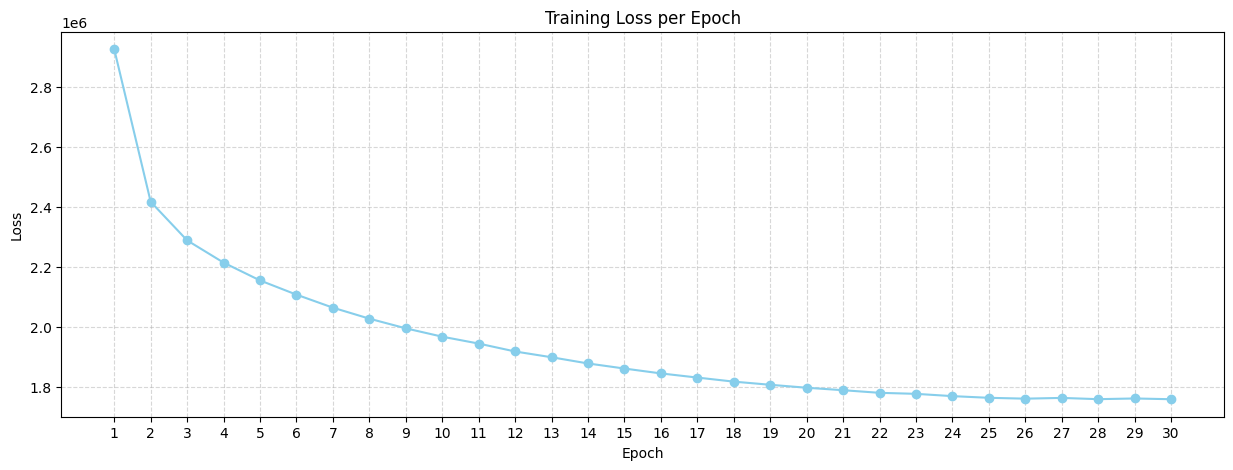

In [23]:
plot_epoch_losses(epoch_losses)

# **Save Embeddings And Word to Index Mappnig**

In [24]:
def save_embeddings_and_vocab(embeddings, word_to_idx, idx_to_word, embeddings_path, word_to_idx_path, idx_to_word_path):
    np.save(embeddings_path, embeddings)
    with open(word_to_idx_path, 'wb') as f:
        pickle.dump(word_to_idx, f)
    with open(idx_to_word_path, 'wb') as f:
        pickle.dump(idx_to_word, f)

In [25]:
save_embeddings_and_vocab(target_vectors, word_to_idx, idx_to_word, 'embeddings.npy', 'word_to_idx.pkl', 'idx_to_word.pkl')

# **Load Embeddings And Word to Index Mappnig**

In [26]:
def load_embeddings_and_vocab(embeddings_path, word_to_idx_path, idx_to_word_path):
    embeddings = np.load(embeddings_path)
    with open(word_to_idx_path, 'rb') as f:
        word_to_idx = pickle.load(f)
    with open(idx_to_word_path, 'rb') as f:
        idx_to_word = pickle.load(f)
    return embeddings, word_to_idx, idx_to_word 

In [27]:
embeddings, word_to_idx, idx_to_word = load_embeddings_and_vocab('embeddings.npy', 'word_to_idx.pkl', 'idx_to_word.pkl')

# **Testing**

In [28]:
vectors_normed = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-10)

def cosine_similarity(a, b):
    return np.dot(a, b)

### **Similar Words**

In [29]:
def most_similar(word, word_to_idx, idx_to_word, vectors_normed, topn=5):
    if word not in word_to_idx:
        print(f"Error: '{word}' not in vocabulary."); return

    idx = word_to_idx[word]
    target = vectors_normed[idx]
    sims = np.dot(vectors_normed, target)
    sims[idx] = -np.inf
    top = np.argsort(sims)[-topn:][::-1]

    print("\n" + "="*50)
    print(f"Most Similar Words to '{word}':")
    print("="*50)
    for i in top:
        print(f"  {idx_to_word[i]:<15} | Similarity: {sims[i]:.4f}")
    print("-"*50 + "\n")

In [30]:
test_words = ['france', 'germany', 'london', 'paris', 'company', 'government']
for w in test_words:
    most_similar(w, word_to_idx, idx_to_word, vectors_normed)


Most Similar Words to 'france':
  carole          | Similarity: 0.5459
  cavagnoud       | Similarity: 0.5437
  montillet       | Similarity: 0.5381
  dalloz          | Similarity: 0.5378
  regine          | Similarity: 0.5352
--------------------------------------------------


Most Similar Words to 'germany':
  katharina       | Similarity: 0.5900
  seizinger       | Similarity: 0.5839
  riedel          | Similarity: 0.5836
  franziska       | Similarity: 0.5823
  hilde           | Similarity: 0.5815
--------------------------------------------------


Most Similar Words to 'london':
  rosemary        | Similarity: 0.6417
  bennett         | Similarity: 0.6372
  ipe             | Similarity: 0.6223
  gdr             | Similarity: 0.6177
  diverted        | Similarity: 0.6096
--------------------------------------------------


Most Similar Words to 'paris':
  germain         | Similarity: 0.7225
  nancy           | Similarity: 0.6182
  st              | Similarity: 0.6006
  bangkok 

### **Word Analogy**

In [31]:
def word_analogy_short(a, b, c, expected, word_to_idx, idx_to_word, vectors):
    # Check vocab
    for w in [a,b,c,expected]:
        if w not in word_to_idx: print(f"Error: '{w}' not in vocabulary."); return

    # Analogy prediction
    vec = vectors[word_to_idx[b]] - vectors[word_to_idx[a]] + vectors[word_to_idx[c]]
    vec /= np.linalg.norm(vec)+1e-10
    sims = np.dot(vectors, vec); sims[[word_to_idx[w] for w in [a,b,c]]] = -np.inf
    pred_idx = np.argmax(sims); pred_word = idx_to_word[pred_idx]

    # Print results
    print("\n" + "="*70)
    print(f"Word Analogy Test: '{a}' : '{b}' :: '{c}' : ?")
    print("="*70)
    print(f"Predicted: {pred_word} ({sims[pred_idx]:.4f}) | Expected: {expected} ({sims[word_to_idx[expected]]:.4f})")
    print("-"*70)

    # Plot canonical analogy
    pts = np.vstack([vectors[word_to_idx[w]] for w in [a,b,c,expected]])
    red = TSNE(n_components=2, random_state=42, init='pca', perplexity=3, learning_rate='auto').fit_transform(pts)
    plt.figure(figsize=(6,6))
    off = 0.3  # increase text distance from points
    colors = ['blue','green','orange','red']; labels=[a,b,c,expected]
    for i,(x,y) in enumerate(red): 
        plt.scatter(x,y,color=colors[i],s=50)
        plt.text(x+off,y-off*10,labels[i],fontsize=8,fontweight='bold')
    
    plt.arrow(*red[0], *(red[1]-red[0]), color='black', width=0.002, head_width=1, length_includes_head=True)
    plt.arrow(*red[2], *(red[3]-red[2]), color='black', width=0.002, head_width=1, length_includes_head=True)
    
    plt.title(f"'{a}' : '{b}' :: '{c}' : '{expected}'"); plt.axis('equal'); plt.grid(True,alpha=0.5)
    plt.show()


Word Analogy Test: 'man' : 'men' :: 'woman' : ?
Predicted: vault (0.6002) | Expected: women (0.5912)
----------------------------------------------------------------------


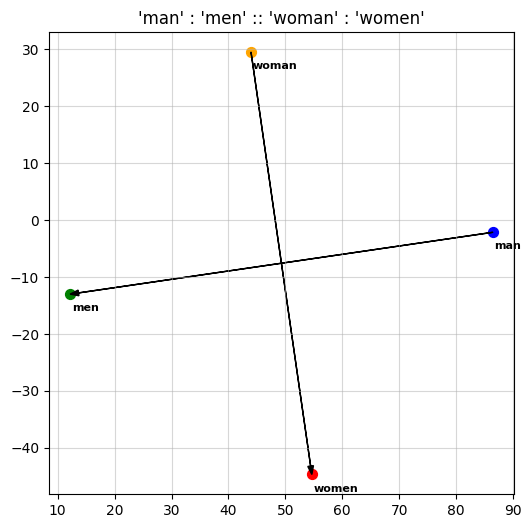


Word Analogy Test: 'big' : 'bigger' :: 'small' : ?
Predicted: malignant (0.6757) | Expected: smaller (0.4680)
----------------------------------------------------------------------


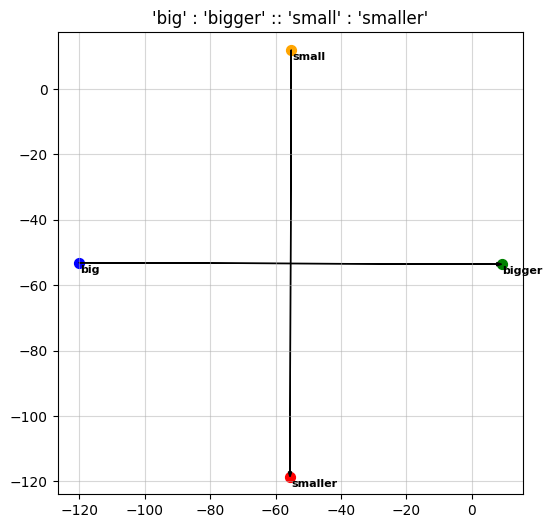


Word Analogy Test: 'good' : 'better' :: 'bad' : ?
Predicted: guys (0.6197) | Expected: worse (0.4787)
----------------------------------------------------------------------


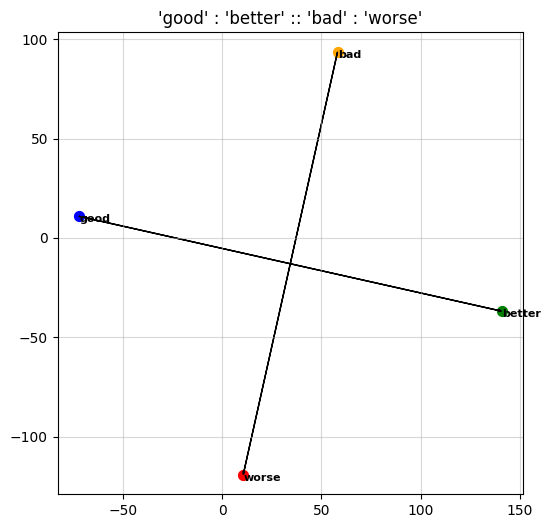

In [32]:
analogies = [
    ('man', 'men', 'woman', 'women'),
    ('big', 'bigger', 'small', 'smaller'),
    ('good', 'better', 'bad', 'worse')
]

for a, b, c, d in analogies:
    word_analogy_short(a, b, c, d, word_to_idx, idx_to_word, vectors_normed)

### **Random Words Similarities**

In [33]:
def random_word_similarity(word_to_idx, idx_to_word, vectors_normed, num_pairs=5):
    words = list(word_to_idx.keys())
    print("\n" + "="*50)
    print(f"Random Word Similarity Test ({num_pairs} Pairs)")
    print("="*50)
    
    for _ in range(num_pairs):
        w1, w2 = random.sample(words, 2)
        idx1, idx2 = word_to_idx[w1], word_to_idx[w2]
        score = np.dot(vectors_normed[idx1], vectors_normed[idx2])
        print(f"  {w1:<15} | {w2:<15} | Similarity: {score:.4f}")
    
    print("-"*50 + "\n")

In [34]:
random_word_similarity(word_to_idx, idx_to_word, vectors_normed, num_pairs = 10)


Random Word Similarity Test (10 Pairs)
  frenz           | tan             | Similarity: 0.5384
  taking          | rodrigo         | Similarity: 0.2472
  yet             | jens            | Similarity: 0.0624
  higher          | rekindled       | Similarity: 0.3015
  tracks          | tricks          | Similarity: 0.3875
  amount          | campbell        | Similarity: 0.2226
  stork           | generally       | Similarity: 0.3860
  probing         | tested          | Similarity: 0.3700
  stationed       | des             | Similarity: 0.2408
  sleeping        | iscor           | Similarity: 0.2955
--------------------------------------------------

